# Training multi-layer perceptron classifiers on probes of differential expression
This notebook attempts a hyperparameter search via cross-validation and the hyeropt hyperparameter optimization library's *tree parzen estimator* algorithm. Altogether four different sets of training/training data from the original microarray data are have MLP classifiers trained over them. Each set of data contains genes differentially expressed in Alzheimer's and Non-diseased samples to varying degrees of significance as determined by a Z-score test detailed in the *Dimensionality Reduction via Z test* notebook. The number of probes in each set and corresponding signiicance threshold used are:

1. 877 probes at significance threshold of 10E-12 
2. 612 probes at significance threshold of 10E-13 
3. 400 probes at significance threshold of 10E-14 
4. 266 probes at significance threshold of 10E-15 

Standardized probe intensities are the features on which the neural networks classify. 

In [2]:
# Include Everything
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, plot_roc_curve

from hyperopt import hp, Trials, fmin, tpe, space_eval, STATUS_OK, STATUS_FAIL
from timeit import default_timer as timer
from statistics import mean

from matplotlib import pyplot as plt

import seaborn as sns

In [3]:
# Generate training and testing data splits for each of the different number of features
data = dict()
feature_sizes = "877 612 400 266".split(" ")


for n_feats in feature_sizes:
    n_feats_data = pd.read_csv(f"../Data/{n_feats}_most_differentially_expressed_probes.csv")
    sample_cols = n_feats_data.columns[1:len(n_feats_data.columns) -1]
    # 80/20 train test split
    train, test = train_test_split(n_feats_data, train_size=0.8, random_state=23)
    # Add the training and test data frames to the data dictionary, without tatget column
    data[f"{n_feats}_train"] = train.loc[:, sample_cols]
    data[f"{n_feats}_test"] = test.loc[:, sample_cols]
    # Save target columns for train/test data in the data dictionary as separate series
    data[f"{n_feats}_train_lbls"] = train["target"]
    data[f"{n_feats}_test_lbls"] = test["target"]


In [5]:
# Define the search space. Dictionaries are in key:value where the value is a probabilistic space to 
# "randomly" chose from (I believe as TPE algorithm works, it changes updates probabilistic distributions)
# The tree structure formed by this dictionary is the tree refered to in TPE
search_space =  hp.choice("layers", [
    # Two hidden layer model using lbfgs solver
    {
        "type": "2_layer_lbfgs",
        "k": hp.quniform("2layers_k",1,7,1), # k is selecting for bias alpha, where alpha = 10^-k [0.1, 0.01, ... 10^-7]
        "l1": hp.qnormal("2layers_l1",150, 65, 1), # Discretized normal dist, mu =150, stdev=65
        "l2": hp.qnormal("2layers_l2",75, 32, 1), #  mu =75, stdev=32,
        "iters": hp.qnormal("2layers_max_iters", 300, 25, 1)
    },
    # Three hidden layer model using lbfgs solver
    {
        "type": "3_layer_lbfgs",
        "k": hp.quniform("3layers_k",1,7,1),
        "l1": hp.qnormal("3layers_l1",150, 65, 1), # Discretized normal dist, mu =150, stdev=65
        "l2": hp.qnormal("3layers_l2",75, 32, 1), # mu =75, stdev=32
        "l3": hp.qnormal("3layers_l3",40, 20, 1), # Discretized normal dist, mu =75, stdev=32
        "iters": hp.qnormal("3layers_max_iters", 300, 35, 1)
    }
])


# Define the optimization function (Costly to run as it implies fitting a MLP classifier via CV)
def objective(architecture):
    """ The objective function to optimize is the 5-fold cross-validation fitting of a 2 hidden layer NN classifier.
        The hyperoptimizer operates as a minimizer, so the returned loss will be the negative of the avg of 
        mean accuracy.
    """
    # Determine classifer hyperparams from architecture dictionary given
    if "l3" in architecture:
        shape = (2, int(architecture["l1"]), int(architecture["l2"]), int(architecture["l3"]))
    else:
        shape = (2, int(architecture["l1"]), int(architecture["l2"]))
    k = architecture["k"]
    iters = architecture["iters"]
    
    # Make a new MLP Classifier
    cfier = MLPClassifier(max_iter=iters, hidden_layer_sizes=shape, solver= "lbfgs", alpha = pow(10, -k))
    
    # Cross Validatae. n_jobs = -1 sets all available cpu cores to work, -2 all but 1 available, etc. 
    results = cross_validate(cfier, X=train_data, y=train_lbls, cv=5, n_jobs=-1)
    # Results must contain a "loss" value for hyperopt to minimize, and the status
    results["loss"] = -1 * mean(results["test_score"]) 
    del results["test_score"]
    # For brevity report means
    results["fit_time"] = mean(results["fit_time"])
    results["score_time"] = mean(results["score_time"])
    results["status"] = STATUS_OK
    
    return results
    


## Use hyperopt to optimize hyperarameters for MLP classifiers different feature sets
Optimize over the four different feature sets of varying significance selection thresholds. Record the best performer for each, as well as the trials results for the hyperparameter search in the performance dictionary for later visualization. 

In [18]:
performance = dict()

for nfeats in feature_sizes:
    # How many features is this model to be trained over?  
    train_data = data[f"{nfeats}_train"]
    train_lbls = data[f"{nfeats}_train_lbls"]

    # Create a trials Hyperopt Object which stores data regarding the results of our hyperparameter search
    trials = Trials()

    # Run the hyperparam search. We'll let the hyperopt lib suggest the tpe to use
    best_performer = fmin(fn=objective, space=search_space, algo=tpe.suggest, trials=trials, max_evals=100, 
                            rstate= np.random.RandomState(32))
    
    # Add results to the performance dictionary
    performance[f"{nfeats}_best"] = best_performer
    mean_acc = [-1 * res['loss'] for res in trials.results]
    fit_time = [res['fit_time'] for res in trials.results]
    performance[f"{nfeats}_mean_acc"] = mean_acc 
    performance[f"{nfeats}_fit_time"] =  fit_time
    performance[f"{nfeats}_best_acc"] = max(mean_acc)

100%|██████████| 100/100 [00:57<00:00,  1.75trial/s, best loss: -0.8848790322580645]


Best performer for 877 features (best mean accuracy 90.4637%):
	layers: 3
	alpha: 0.0001
	Training Iterations: 318.0
	iterations: 318.0
	l1 neurons: 177.0
	l2 neurons: 89.0
	l3 neurons: 34.0
Best performer for 612 features (best mean accuracy 91.0484%):
	layers: 2
	alpha: 0.1
	Training Iterations: 244.0
	iterations: 244.0
	l1 neurons: 57.0
	l2 neurons: 128.0
Best performer for 400 features (best mean accuracy 90.3831%):
	layers: 3
	alpha: 0.01
	Training Iterations: 336.0
	iterations: 336.0
	l1 neurons: 168.0
	l2 neurons: 27.0
	l3 neurons: 72.0
Best performer for 266 features (best mean accuracy 88.4879%):
	layers: 2
	alpha: 1e-05
	Training Iterations: 315.0
	iterations: 315.0
	l1 neurons: 186.0
	l2 neurons: 113.0


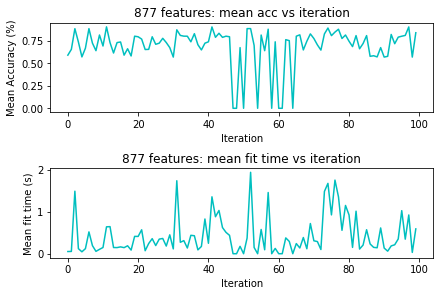

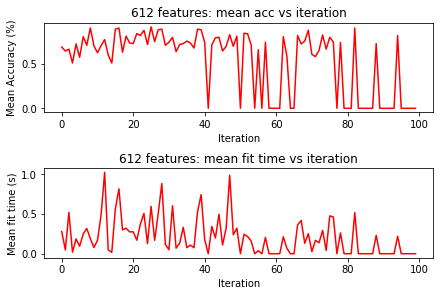

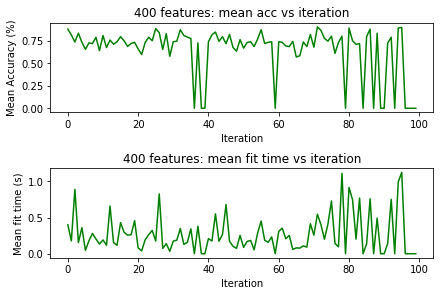

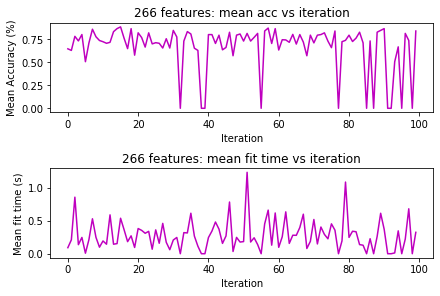

In [21]:
# Report the results and visualize the training progress of mean accuracy and iteration 

figs = []
axes = []
colors = ["c", "r", "g", "m"]

for i, nfeats in enumerate(feature_sizes):
    best = performance[f"{nfeats}_best"]
    layers = best["layers"] + 2
    alpha = pow(10, -1*best[f"{layers}layers_k"])
    iters = best[f"{layers}layers_max_iters"]
    l1_neurons = best[f"{layers}layers_l1"]
    l2_neurons = best[f"{layers}layers_l2"]
    best_acc = performance[f"{nfeats}_best_acc"]
    print(f"Best performer for {nfeats} features (best mean accuracy {best_acc:.4%}):")
    print(f"\tlayers: {layers}")
    print(f"\talpha: {alpha}")
    print(f"\tTraining Iterations: {iters}")
    print(f"\titerations: {iters}")
    print(f"\tl1 neurons: {l1_neurons}")
    print(f"\tl2 neurons: {l2_neurons}")
    if layers == 3:
        l3_neurons = best[f"{layers}layers_l3"]
        print(f"\tl3 neurons: {l3_neurons}")
    
    # figures containing plots of mean accuracy and mean time to fit model for each hyperparam search iteration
    fig, axs = plt.subplots(2, 1, constrained_layout=True)
    mean_acc = pd.Series(performance[f"{nfeats}_mean_acc"]).fillna(value=0) # Replace NaNs with 0's
    axs[0].plot(mean_acc, c=colors[i])
    axs[0].set_title(f"{nfeats} features: mean acc vs iteration")
    axs[0].set_xlabel("Iteration")
    axs[0].set_ylabel("Mean Accuracy (%)")
    axs[1].plot(performance[f"{nfeats}_fit_time"], c=colors[i])
    axs[1].set_title(f"{nfeats} features: mean fit time vs iteration")
    axs[1].set_xlabel("Iteration")
    axs[1].set_ylabel("Mean fit time (s)")
    
    figs.append(fig)
    axes.append(axs)

## Training and Testing
Fit the most promising architectures from the hyperparameter searchs on each of the feature sets. Test and report on results with:
- Confusion Matrices
- ROC diagrams with AuC
- sciki-learn's classification report

In [39]:
# Train the models

names = [f"{n}_best" for n in feature_sizes]
# dicionary of the MLP classifiers to be trained for each of the various feature counts
cfiers = {f"{n} feature classifier":None for n in feature_sizes}

for name in names:
    n = name.strip("_best")
    best_architecture = performance[name]
    layers = best_architecture["layers"] + 2 
    # Cast the layer neuron counts to int 
    l1 = int(best_architecture[f"{layers}layers_l1"])
    l2 = int(best_architecture[f"{layers}layers_l2"])
    k = best_architecture[f"{layers}layers_k"]
    iters = best_architecture[f"{layers}layers_max_iters"]
    if 3 == layers:
        l3 = int(best_architecture[f"{layers}layers_l3"])
        cfier = MLPClassifier(max_iter=iters, hidden_layer_sizes=(3,l1,l2,l3), 
                              solver= "lbfgs", alpha = pow(10, -k), random_state=3)
    else:
        cfier = MLPClassifier(max_iter=iters, hidden_layer_sizes=(2,l1,l2), 
                      solver= "lbfgs", alpha = pow(10, -k), random_state=27)
        
    # Report on the architecture
    print(f"{name.replace('_best',' features')} classifier architecture")
    print(f"\tlayers: {layers}")
    print(f"\tl1 neurons: {l1}")
    print(f"\tl2 neurons: {l2}")
    if layers == 3:
        print(f"\tl3: {l3}")
    print(f"\talpha: {pow(10, -k)}")
    print(f"\ttraining iterations {iters}")

    # Fit and place in the classifiers dictionary
    train_data = data[f"{n}_train"]
    train_lbls = data[f"{n}_train_lbls"]
    cfier.fit(X=train_data, y=train_lbls)
    cfiers[name.strip("_best") + " feature classifier"] = cfier


877 features classifier architecture
	layers: 3
	l1 neurons: 177
	l2 neurons: 89
	l3: 34
	alpha: 0.0001
	training iterations 318.0
612 features classifier architecture
	layers: 2
	l1 neurons: 57
	l2 neurons: 128
	alpha: 0.1
	training iterations 244.0


/home/mike/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


400 features classifier architecture
	layers: 3
	l1 neurons: 168
	l2 neurons: 27
	l3: 72
	alpha: 0.01
	training iterations 336.0
266 features classifier architecture
	layers: 2
	l1 neurons: 186
	l2 neurons: 113
	alpha: 1e-05
	training iterations 315.0


/home/mike/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Classification Report for 877 feature classifier
               precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.95      1.00      0.97        18

    accuracy                           0.97        39
   macro avg       0.97      0.98      0.97        39
weighted avg       0.98      0.97      0.97        39

Classification Report for 612 feature classifier
               precision    recall  f1-score   support

           0       0.95      1.00      0.98        21
           1       1.00      0.94      0.97        18

    accuracy                           0.97        39
   macro avg       0.98      0.97      0.97        39
weighted avg       0.98      0.97      0.97        39

Classification Report for 400 feature classifier
               precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.95      1.00      0.97        18

    accuracy                    

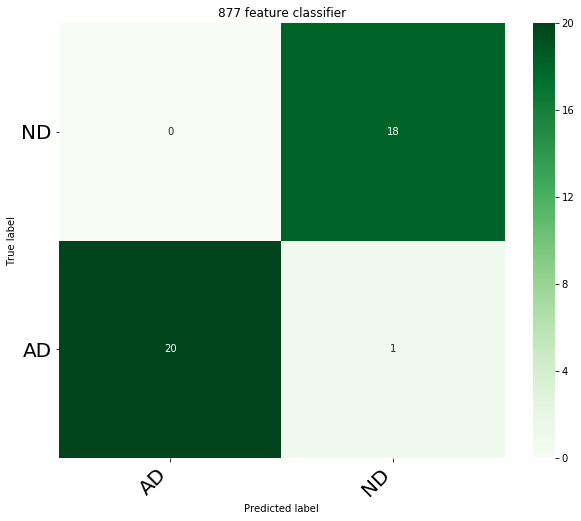

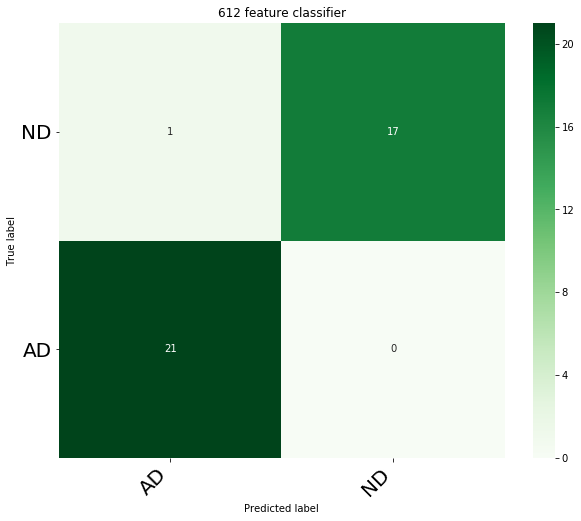

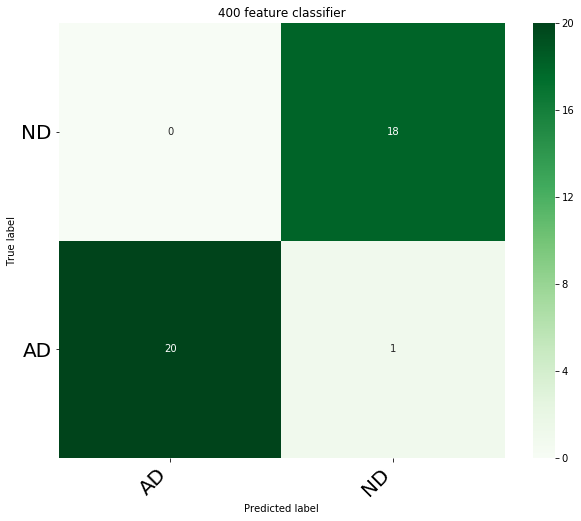

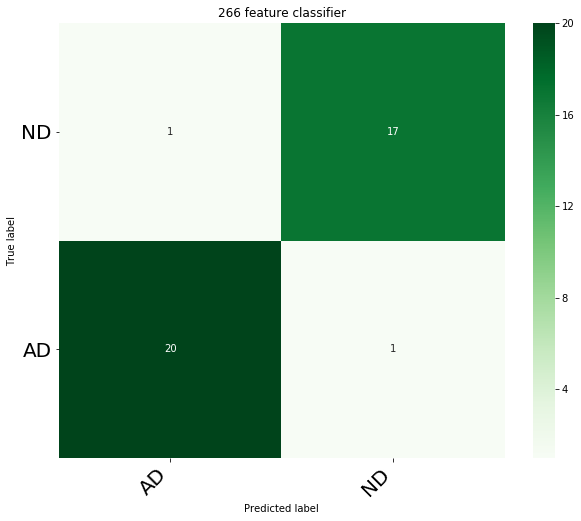

In [40]:
from print_conf_mat import *
# Test performance and visualize the results
c_mat_figs = []

for name, cfier in cfiers.items():
    n = name.split(" ")[0] # Gets the number of features from the cfier name
    test_data = data[f"{n}_test"]
    test_lbls = data[f"{n}_test_lbls"]
    predictions = cfier.predict(test_data)
    c_mat = confusion_matrix(test_lbls, predictions)
    report = classification_report(test_lbls, predictions)
    print(f"Classification Report for {name}\n {report}")
    # Pretty print the confusion matrix
    fig = print_confusion_matrix(c_mat, ["AD", "ND"], figsize=(10,8), fontsize=20, title=name)
    # y-axis annotation alignment goofs up on some versions of matplitlib.  
    # If this is the case, comment/uncomment the following line
    fig.gca().set_ylim([0,2])

    c_mat_figs.append(fig)
    

## ROC curves with AUC

877 feature classifier
612 feature classifier
400 feature classifier
266 feature classifier


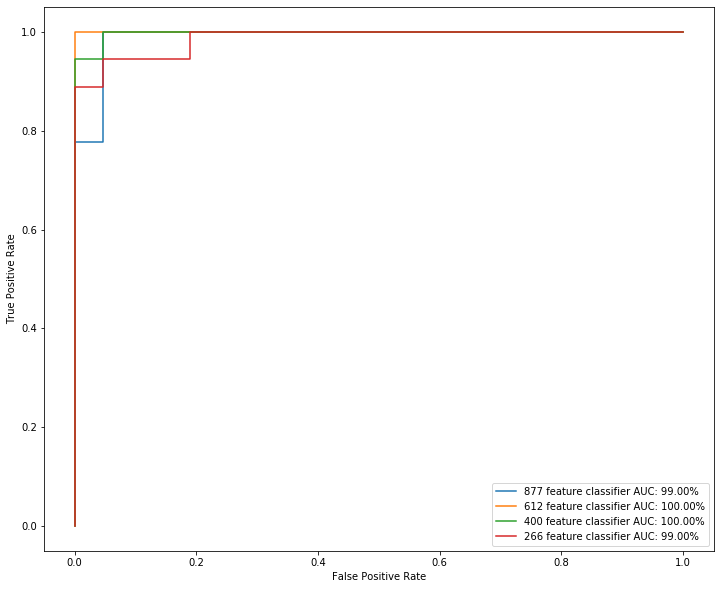

In [45]:
fig = plt.figure(figsize = (12,10))
ax = fig.gca()
scrs = {"877 feature classifier":.99, "612 feature classifier":1, "400 feature classifier":1, 
 "266 feature classifier":.99}
for name, cfier in cfiers.items():
    n = name.split(" ")[0] # Gets the number of features from the cfier name
    test_data = data[f"{n}_test"]
    test_lbls = data[f"{n}_test_lbls"]
    predictions = cfier.predict(test_data)
    auc_score = roc_auc_score(test_lbls, predictions)
    auc = scrs[name]
    plot_roc_curve(cfier, X=test_data, y=test_lbls, ax=ax, label=f"{name} AUC: {auc:.2%}")
